![Screenshot from 2025-04-27 00-39-49.png](<attachment:Screenshot from 2025-04-27 00-39-49.png>)
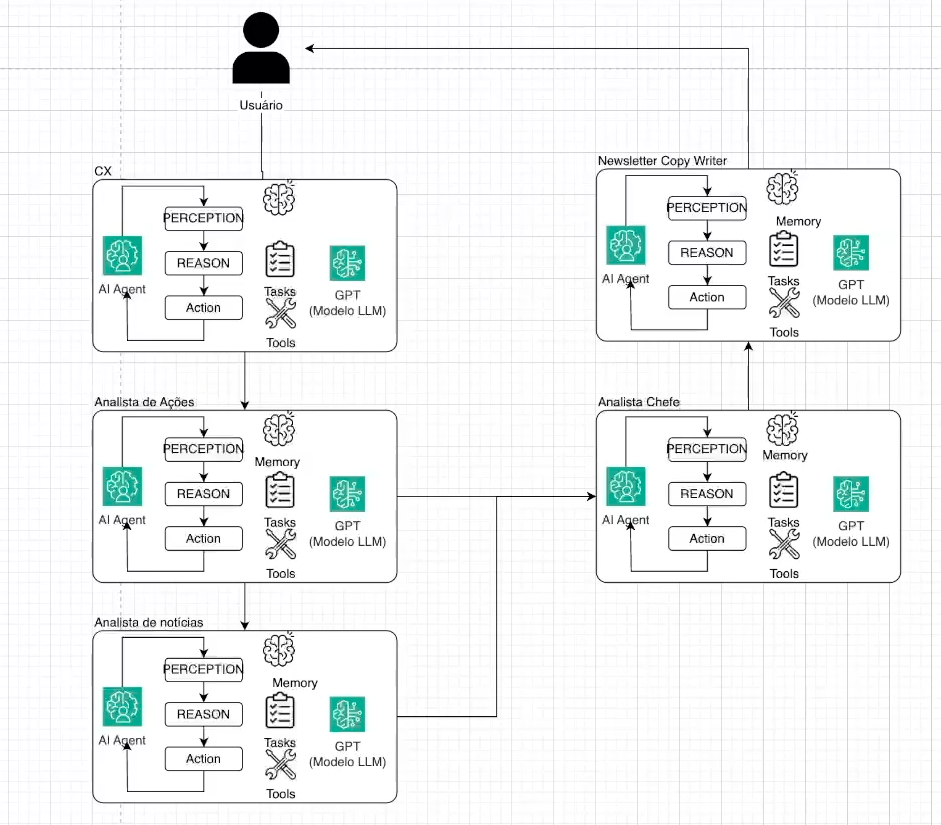

In [ ]:
# libs utilizadas
%pip install yfinance==0.2.44 
%pip install crewai==0.70.1
%pip install crewai-tools==0.12.1
%pip install langchain==0.2.16
%pip install langchain-community==0.2.17
%pip install langchain-openai==0.1.25
%pip install duckduckgo_search==6.3.0  #lib para fazer pesquisa na internet

In [ ]:
import json
import os
from datetime import datetime, timedelta

from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from crewai_tools import CSVSearchTool
import yfinance as yf
from langchain.tools import Tool
from langchain_community.tools import DuckDuckGoSearchResults
from IPython.display import Markdown

In [ ]:
os.environ['OPENAI_API_KEY']= ""
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [ ]:
csvWalletTool = CSVSearchTool(csv='./Wallet/wallet.csv')

In [ ]:
# Criação dos agentes

# 1- Customer Manager
customerManager = Agent(
    role = "Customer Stocks Manager",
    goal="Get the customer question about the stock {ticket} and search the customer wallet CSV file for the stocks.",
    backstory="""
      You're the manager of the customer investiments wallet.
      You're the client first contact and you provide the other analystis with the necessary stock ticket and wallet information.
    """,
    verbose=True,
    llm=llm,
    max_inter=5,
    tools=[csvWalletTool],
    allow_delegation=False,
    memory=True # Setar memória
)

In [ ]:
# task do customer manager
getCustomerWallet = Task(
    description="""
     Use the customer question and find the {ticket} is the CSV file.
     Provide if the stock is in the customer wallet and if it is, provide with the mean price he paid
     and the total numbers of stocks owned.
   """,
   expected_output="If the customer owns the stocks, provide the mean price paid and the total stock numbers.",
   agent=customerManager
)

In [ ]:
# O agente quefará o papel de analista de mercado
stockerPriceAnalyst = Agent(
    role="Senopr Stock Price Analyst",
    goal="Find the {ticket} stock price and analyses price trends. Compare with the price that the customer paid.",
    backstory="""
    You're a highly  experienced in analyzing the price of specific stocks and make predictions about its future price
    """,
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=False,
    memory=True
)

In [ ]:
# criando yahoo finance tools
def fetch_stock_price(ticket):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    stock = yf.download(ticket, start=start_date.strftime('%Y-%M-%D'), end=end_date.strftime('%Y-%M-%D'))
    return stock

yahoo_finance_tool = Tool(
    name="Yahoo Finance Tool",
    description= "Fetches stocks prices for {ticket} from the last year about a specific company from the Yahoo Finance API",
    func= lambda ticket: fetch_stock_price(ticket)
)

In [ ]:
# task para o analista de mercado
getStockPrice = Task(
    description="Analyze the stock {tocket} price and create a price trend analyses of up, down or sideways",
    expected_output="""
     Specify the current trend stocks price - Up, down or sideway.
     eg. stock = 'AAPL, price UP'.
     """,
    tools = [yahoo_finance_tool],
    agent= stockerPriceAnalyst
)

In [ ]:
# Agente de analista de noticias do mercado
newsAnalyst = Agent(
    role="News Analyst",
    goal="""
      Create a short summary of the market news related to the stock {ticket} company.
      Provide a market sentiment score about the company.
      For each request requested stock asset, specify a number between 8 and 100, where 8 is extreme fear and 100 is extreme greed.
    """,
    backstory="""
     You're highly experienced in analyzing market trends and news for more then 10 years.
     You're also a master level analyst in the human psychology.
     You undestand the news, their title and information, but you look at those with a health dose of skeptcism.
     You consider the source of the news articles.
    """,
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=False,
    memory=True
)

In [ ]:
seachTool = DuckDuckGoSearchResults(backend='news', num_results=10)

In [ ]:
# Task para o agente analista de notícias do mercado
getNews = Task(
    description=f""" 
      Use the serach tool to serach news about the stok ticket.
      The current date is {datetime.now()}
      Compose the results into a helpfull report.
    """,
    expected_output="""
      A summary of the overall market and one paragraph summary for the request asset.
      Include the fear/greed score based on the news. Use format:
      <STOCK TICKET>
      <SUMMARY BASED ON NEWS>
      >FEAR/GREED SCORE>
    """,
    agent=newsAnalyst,
    tool=[seachTool]
)

In [ ]:
# Agente do Analista Chefe que irá fazer recomendações
stockRecommender = Agent(
    role="Chief Stock Analyst",
    goal="""
     Get the data from the customer currently stocks, the provided input of stock price trends and
     the stock news to provide a recommendation: Buy, Sell or Hold the stock
    """,
    backstory="""
      You're the leader of the stock analyst team. You have a great performance in the past 20 years in stock recommendations with all
      your team informations, you are able to provide the best recommendation for the customer to achieve
      the maximum value creation.
    """,
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=True, # esse agente poderá delegar tarefas
    memory=True
)

In [ ]:
# Task do analista chefe
recommendStock = Task(
    description="""
     Use the stock price trend, the stock news report and the customers stock mean price of the {ticket}
     to provide a recommendation: Buy, Sell or hold. If the previous reports are not well provided you can delegate back
     to run specific analyst to work again in the their task.
    """,
    expected_output="""
     A brief paragraph with the summary of the reasons for recommendation and the
     recomendation it self in one of the three possible outputs: Buy, Sell or Hold. use the format:
     <SUMMARY OF REANSONS>
     <RECOMMENDATION>
    """,
    agent= stockRecommender,
    context = [getCustomerWallet, getStockPrice, getNews] # Ele precisa do output dessas tasks para tomar sua decisão
)

In [ ]:
# Por fim o agente que irá transmitir o informativo para o usuário
copyWriter=Agent(
    role="Stock Content Writer",
    goal="""Write an insightfull compelling and informative & paragraph long newletter
    based on the stock price report, the news report and the recommendation report
    """,
    backstory="""You are a unbelieveble copy writer that understand complex financel concepts
    and explain for a dummie audience.
    You create complelling stories and narratives that resonate with audience.
    """,
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=False,
    memory=True
)

In [ ]:
# Task para o agente copy writer
writeNewsletter=Task(
    description="""Use the stock price trend, the stock news report and the stock recommendation to write an insightfull article.
     Focus on the stock price trend, the news, the fear/greed score and the summary reason for the recommendation.
    """,
    expected_output="""
     An eloquent 6 paragraph newsletter formated as Markfown in an easy readable manner. It should contain:
     - Introduction - Set the overal picture
     - Main part - Provides the meat of the analysis including stock price trend, the news, the fear/greed scor and the summary reason.
     - 3 bullets of the main summary reason of the recommendation.
     - Recommendation Summary
     - Recommendatuon it self
   """,
   agent=copyWriter,
   context=[getStockPrice, getNews,recommendStock]
)

In [ ]:
crew = Crew(
    agents = [customerManager,stockerPriceAnalyst,newsAnalyst,stockRecommender,copyWriter],
    tasks = [getCustomerWallet, getStockPrice,getNews,recommendStock,writeNewsletter],
    verbose=True,
    process=Process.hierarchical,
    full_output=True,
    share_crew=False,
    manager_llm=llm,
    max_item=15
)

In [ ]:
result = crew.kickoff(inputs={'ticket':'Amazon'})

In [ ]:
result.raw

In [ ]:
Markdown(result.raw)